## Markov Blanket Estimation: Error Analysis

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
from src import evaluation, policy, utils
import multiprocessing
import os

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

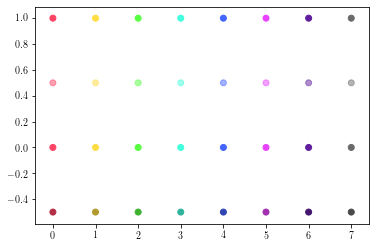

In [3]:
# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

### Generate test cases

In [4]:
G = 1000
cases = evaluation.gen_cases(G,
                             P = 12,
                             k = 3,
                             w_min = 0.5,
                             w_max = 1,
                             var_min = 0,
                             var_max = 1,
                             int_min = 0,
                             int_max = 1,
                             random_state = 0)
print("Generated %d SCMs" % len(cases))

Generated 1000 SCMs


1000 graphs in total


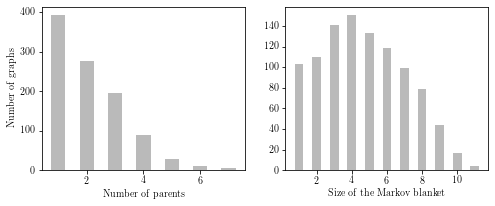

In [5]:
n_parents = np.zeros(G)
n_vars = np.zeros(G)
size_mb = np.zeros(G)
for i, case in enumerate(cases):
    n_parents[i] = len(case.truth)
    n_vars[i] = case.sem.p
    mb = utils.graph_info(case.target, case.sem.W)[3]
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(8,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(121), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(122), plot_hist(size_mb, "Size of the Markov blanket")
print("%d graphs in total" % G)

max_parents, min_parents = int(n_parents.max()), int(n_parents.min())

### Compute estimates for different sample sizes

In [6]:
%%time

N = [10,30,100,300,1000]

estimates = {}

# Computation

def comp_estimates(n):
    estimates = []
    #print("", end="\r")
    for i,case in enumerate(cases):
        #print("n=%d Case %d/%d" % (n, i, G), end="\r") if i % 10 == 0 else None
        sample = case.sem.sample(n)
        estimate = set(policy.markov_blanket(sample, case.target, debug=False))
        estimates.append(estimate)
    return estimates

n_workers = os.cpu_count() - 1
print("Evaluation with %d workers" % n_workers)
pool = multiprocessing.Pool(n_workers)

estimates_by_n = pool.map(comp_estimates, N)
print("Done")

Evaluation with 3 workers
Done
CPU times: user 323 ms, sys: 97.2 ms, total: 420 ms
Wall time: 9min 41s


In [7]:
len(estimates_by_n[0])

1000

### Analysis

In [8]:
def estimate_size(estimates_by_n):
    results_by_n = []
    for estimates in estimates_by_n:
        result = np.array(list(map(lambda estimate: len(estimate), estimates))).mean()
        results_by_n.append(result)
    return results_by_n

def proportion_superset(estimates_by_n):
    results_by_n = []
    for estimates in estimates_by_n:
        results = []
        for i, estimate in enumerate(estimates):
            true_mb = utils.graph_info(cases[i].target, cases[i].sem.W)[3]
            results.append(set.issuperset(estimate, true_mb))
        results_by_n.append(np.mean(results))
    return results_by_n

def contains_parents(estimates_by_n, parent_size=None):
    results_by_n = []
    for estimates in estimates_by_n:
        results = []
        for i,estimate in enumerate(estimates):
            if len(cases[i].truth) == parent_size or parent_size is None:
                results.append(set.issuperset(estimate, cases[i].truth))        
        results_by_n.append(np.mean(results))
    return results_by_n

def estimate_size_when_contains_parents(estimates_by_n, parent_size=None):
    results_by_n = []
    for estimates in estimates_by_n:
        results = []
        for i,estimate in enumerate(estimates):
            if len(cases[i].truth) == parent_size or parent_size is None:
                if set.issuperset(estimate, cases[i].truth):
                    results.append(len(estimate))
        results_by_n.append(np.mean(results))
    return results_by_n

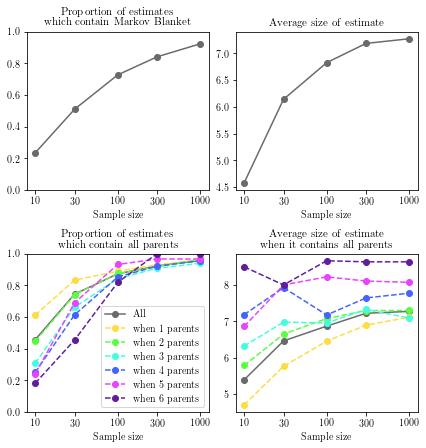

In [9]:
gs = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.4)
plt.figure(figsize=(7,7))

# Proportion of estimates which are superset
plt.subplot(gs[0])
ax = plt.gca()
ax.plot(np.log10(N), proportion_superset(estimates_by_n), marker="o", color=colors[7])
ax.set_xticks(np.log10(N))
ax.set_xticklabels(N)
ax.text(0.5,1.04,"Proportion of estimates\nwhich contain Markov Blanket", transform=ax.transAxes, fontsize=11, ha="center")
plt.xlabel("Sample size")
plt.ylim(0,1)

# Average size of estimate
plt.subplot(gs[1])
ax = plt.gca()
ax.plot(np.log10(N), estimate_size(estimates_by_n), marker="o", color=colors[7])
ax.set_xticks(np.log10(N))
ax.set_xticklabels(N)
ax.text(0.5,1.04,"Average size of estimate", transform=ax.transAxes, fontsize=11, ha="center")
plt.xlabel("Sample size")

# Proportion of estimates which are superset
plt.subplot(gs[2])
ax = plt.gca()
for p in range(max_parents):
    if p == 0:
        ax.plot(np.log10(N), contains_parents(estimates_by_n), marker="o", label="All", color=colors[7])
    else:
        ax.plot(np.log10(N), contains_parents(estimates_by_n, p), marker="o", label="when %d parents" % p, color=colors[p], linestyle="--")
ax.set_xticks(np.log10(N))
ax.set_xticklabels(N)
ax.text(0.5,1.04,"Proportion of estimates\nwhich contain all parents", transform=ax.transAxes, fontsize=11, ha="center")
plt.xlabel("Sample size")
plt.legend()
plt.ylim(0,1)

# Average size of estimate when it contains parents
plt.subplot(gs[3])
ax = plt.gca()
for p in range(max_parents):
    if p == 0:
        ax.plot(np.log10(N), estimate_size_when_contains_parents(estimates_by_n), marker="o", label="All", color=colors[7])
    else:
        ax.plot(np.log10(N), estimate_size_when_contains_parents(estimates_by_n, p), marker="o", label="when %d parents" % p, color=colors[p], linestyle="--")
ax.set_xticks(np.log10(N))
ax.set_xticklabels(N)
ax.text(0.5,1.04,"Average size of estimate\nwhen it contains all parents", transform=ax.transAxes, fontsize=11, ha="center")
plt.xlabel("Sample size")
plt.savefig("figures/mb_estimation.pdf", bbox_inches='tight')